In [1]:
from benchmark import *
from utils import *

from cellxgene_census.experimental.ml import ExperimentDataPipe, experiment_dataloader
import torch
from torch.utils.data import DataLoader
torch.ones(2).cuda();

### [Papermill](https://papermill.readthedocs.io/en/latest/) params:

In [2]:
# None ⟹ fetch from S3
census_uri = None
#census_uri = '/mnt/nvme/s3/cellxgene-census-public-us-west-2/cell-census/2023-12-15/soma'
census_version = "2023-12-15"

# By default:
# - `local` if `census_uri` is a local path
# - current region if `census_uri` is None (e.g. `us-east-1`, `us-west-2`)
census_loc = None

collection_id = '283d65eb-dd53-496d-adb7-7570c7caa443'
# Slice datasets from `collection_id`
start = 2
end = 7

n_epochs = 1
batch_size = 1024
n_vars = 20_000
soma_chunk_size = 10_000
gc_freq: Optional[int] = None  # When set, run `gc.collect()` every `gc_freq` batches
exclude_first_batch = True

# Plot configs
ann_cutoff = .5  # Annotate plot with values for batch timings greater than this threshold
log_plot = False
width = 1200
height = 700

In [3]:
# Parameters
census_uri = ""


In [4]:
if not census_uri:
    census_uri = None

if census_loc is None:
    if census_uri and census_uri.startswith('/'):
        census_loc = 'local'
    else:
        census_loc = get_region()

err(f"Using {census_loc} census")

Using us-west-2 census


In [5]:
with profile('open_soma'):
    census = cellxgene_census.open_soma(uri=census_uri, census_version=census_version)

datasets = get_datasets(census, collection_id, 'datasets')
len(datasets), datasets[:10]

(138,
 ['8e10f1c4-8e98-41e5-b65f-8cd89a887122',
  'b165f033-9dec-468a-9248-802fc6902a74',
  'ff7d15fa-f4b6-4a0e-992e-fd0c9d088ded',
  'fe1a73ab-a203-45fd-84e9-0f7fd19efcbd',
  'fbf173f9-f809-4d84-9b65-ae205d35b523',
  'fa554686-fc07-44dd-b2de-b726d82d26ec',
  'f9034091-2e8f-4ac6-9874-e7b7eb566824',
  'f8dda921-5fb4-4c94-a654-c6fc346bfd6d',
  'f7d003d4-40d5-4de8-858c-a9a8b48fcc67',
  'f6d9f2ad-5ec7-4d53-b7f0-ceb0e7bcd181'])

In [6]:
experiment = census["census_data"]["homo_sapiens"]
experiment

<Experiment 's3://cellxgene-census-public-us-west-2/cell-census/2023-12-15/soma/census_data/homo_sapiens' (open for 'r') (2 items)
    'ms': 's3://cellxgene-census-public-us-west-2/cell-census/2023-12-15/soma/census_data/homo_sapiens/ms' (unopened)
    'obs': 's3://cellxgene-census-public-us-west-2/cell-census/2023-12-15/soma/census_data/homo_sapiens/obs' (unopened)>

In [7]:
def get_exp_datapipe(start=None, end=None) -> Exp:
    ds = datasets[slice(start, end)]
    datasets_query = "dataset_id in " + str(ds)
    experiment_datapipe = ExperimentDataPipe(
        experiment,
        measurement_name="RNA",
        X_name="raw",
        obs_query=AxisQuery(value_filter=datasets_query),
        var_query=AxisQuery(coords=(slice(n_vars - 1),)) if n_vars else None,
        batch_size=batch_size,
        shuffle=True,
        soma_chunk_size=soma_chunk_size,
    )
    loader = experiment_dataloader(experiment_datapipe)
    return Exp(experiment_datapipe, loader)

In [8]:
%%time
with profile('get_exp_datapipe'):
    exp = get_exp_datapipe(start=start, end=end)
exp.datapipe.shape[0]

CPU times: user 8.31 s, sys: 2.6 s, total: 10.9 s
Wall time: 2.14 s


133790

## Run benchmark

In [9]:
%%time
epochs = []
for epoch in range(n_epochs):
    with profile(f'benchmark-epoch{epoch}'):
        epoch = benchmark(exp, batch_size=batch_size, gc_freq=gc_freq, exclude_first_batch=exclude_first_batch)
    epochs.append(epoch)

results = Results(
    census=Method('census', epochs),
)

  0%|                                                                                            | 0/130 [00:00<?, ?it/s]

  1%|▋                                                                                   | 1/130 [00:00<00:20,  6.33it/s]

  2%|█▎                                                                                  | 2/130 [00:00<00:16,  7.61it/s]

  2%|█▉                                                                                  | 3/130 [00:00<00:18,  6.84it/s]

  3%|██▌                                                                                 | 4/130 [00:00<00:18,  6.65it/s]

  4%|███▏                                                                                | 5/130 [00:00<00:22,  5.68it/s]

  5%|███▉                                                                                | 6/130 [00:01<00:25,  4.90it/s]

  5%|████▌                                                                               | 7/130 [00:01<00:26,  4.56it/s]

  6%|█████▏                                                                              | 8/130 [00:01<00:27,  4.47it/s]

  7%|█████▊                                                                              | 9/130 [00:07<04:17,  2.13s/it]

  8%|██████▍                                                                            | 10/130 [00:08<03:01,  1.52s/it]

  8%|███████                                                                            | 11/130 [00:08<02:10,  1.10s/it]

  9%|███████▋                                                                           | 12/130 [00:08<01:36,  1.22it/s]

 10%|████████▎                                                                          | 13/130 [00:08<01:13,  1.59it/s]

 11%|████████▉                                                                          | 14/130 [00:08<00:59,  1.93it/s]

 12%|█████████▌                                                                         | 15/130 [00:09<00:51,  2.25it/s]

 12%|██████████▏                                                                        | 16/130 [00:09<00:44,  2.55it/s]

 13%|██████████▊                                                                        | 17/130 [00:09<00:40,  2.78it/s]

 14%|███████████▍                                                                       | 18/130 [00:13<02:33,  1.37s/it]

 15%|████████████▏                                                                      | 19/130 [00:13<01:50,  1.00it/s]

 15%|████████████▊                                                                      | 20/130 [00:13<01:20,  1.37it/s]

 16%|█████████████▍                                                                     | 21/130 [00:13<01:00,  1.80it/s]

 17%|██████████████                                                                     | 22/130 [00:13<00:46,  2.32it/s]

 18%|██████████████▋                                                                    | 23/130 [00:14<00:37,  2.86it/s]

 18%|███████████████▎                                                                   | 24/130 [00:14<00:32,  3.30it/s]

 19%|███████████████▉                                                                   | 25/130 [00:14<00:29,  3.57it/s]

 20%|████████████████▌                                                                  | 26/130 [00:14<00:27,  3.83it/s]

 21%|█████████████████▏                                                                 | 27/130 [00:20<03:27,  2.01s/it]

 22%|█████████████████▉                                                                 | 28/130 [00:20<02:27,  1.45s/it]

 22%|██████████████████▌                                                                | 29/130 [00:21<01:47,  1.06s/it]

 23%|███████████████████▏                                                               | 30/130 [00:21<01:19,  1.26it/s]

 24%|███████████████████▊                                                               | 31/130 [00:21<01:00,  1.64it/s]

 25%|████████████████████▍                                                              | 32/130 [00:21<00:48,  2.04it/s]

 25%|█████████████████████                                                              | 33/130 [00:21<00:41,  2.36it/s]

 26%|█████████████████████▋                                                             | 34/130 [00:22<00:36,  2.65it/s]

 27%|██████████████████████▎                                                            | 35/130 [00:22<00:36,  2.63it/s]

 28%|██████████████████████▉                                                            | 36/130 [00:22<00:32,  2.90it/s]

 28%|███████████████████████▌                                                           | 37/130 [00:28<02:56,  1.90s/it]

 29%|████████████████████████▎                                                          | 38/130 [00:28<02:06,  1.37s/it]

 30%|████████████████████████▉                                                          | 39/130 [00:28<01:30,  1.00it/s]

 31%|█████████████████████████▌                                                         | 40/130 [00:28<01:07,  1.34it/s]

 32%|██████████████████████████▏                                                        | 41/130 [00:28<00:50,  1.75it/s]

 32%|██████████████████████████▊                                                        | 42/130 [00:29<00:39,  2.24it/s]

 33%|███████████████████████████▍                                                       | 43/130 [00:29<00:33,  2.61it/s]

 34%|████████████████████████████                                                       | 44/130 [00:29<00:28,  2.97it/s]

 35%|████████████████████████████▋                                                      | 45/130 [00:29<00:25,  3.28it/s]

 35%|█████████████████████████████▎                                                     | 46/130 [00:34<02:20,  1.67s/it]

 36%|██████████████████████████████                                                     | 47/130 [00:34<01:40,  1.21s/it]

 37%|██████████████████████████████▋                                                    | 48/130 [00:34<01:11,  1.14it/s]

 38%|███████████████████████████████▎                                                   | 49/130 [00:35<00:53,  1.52it/s]

 38%|███████████████████████████████▉                                                   | 50/130 [00:35<00:40,  1.97it/s]

 39%|████████████████████████████████▌                                                  | 51/130 [00:35<00:32,  2.42it/s]

 40%|█████████████████████████████████▏                                                 | 52/130 [00:35<00:27,  2.80it/s]

 41%|█████████████████████████████████▊                                                 | 53/130 [00:35<00:24,  3.14it/s]

 42%|██████████████████████████████████▍                                                | 54/130 [00:36<00:22,  3.45it/s]

 42%|███████████████████████████████████                                                | 55/130 [00:42<02:42,  2.17s/it]

 43%|███████████████████████████████████▊                                               | 56/130 [00:42<01:55,  1.56s/it]

 44%|████████████████████████████████████▍                                              | 57/130 [00:42<01:23,  1.15s/it]

 45%|█████████████████████████████████████                                              | 58/130 [00:43<01:01,  1.17it/s]

 45%|█████████████████████████████████████▋                                             | 59/130 [00:43<00:47,  1.50it/s]

 46%|██████████████████████████████████████▎                                            | 60/130 [00:43<00:38,  1.82it/s]

 47%|██████████████████████████████████████▉                                            | 61/130 [00:43<00:32,  2.13it/s]

 48%|███████████████████████████████████████▌                                           | 62/130 [00:44<00:27,  2.44it/s]

 48%|████████████████████████████████████████▏                                          | 63/130 [00:44<00:24,  2.68it/s]

 49%|████████████████████████████████████████▊                                          | 64/130 [00:44<00:22,  2.91it/s]

 50%|█████████████████████████████████████████▌                                         | 65/130 [00:48<01:28,  1.36s/it]

 51%|██████████████████████████████████████████▏                                        | 66/130 [00:48<01:03,  1.01it/s]

 52%|██████████████████████████████████████████▊                                        | 67/130 [00:48<00:45,  1.38it/s]

 52%|███████████████████████████████████████████▍                                       | 68/130 [00:48<00:34,  1.82it/s]

 53%|████████████████████████████████████████████                                       | 69/130 [00:48<00:26,  2.33it/s]

 54%|████████████████████████████████████████████▋                                      | 70/130 [00:49<00:20,  2.90it/s]

 55%|█████████████████████████████████████████████▎                                     | 71/130 [00:49<00:17,  3.28it/s]

 55%|█████████████████████████████████████████████▉                                     | 72/130 [00:49<00:16,  3.48it/s]

 56%|██████████████████████████████████████████████▌                                    | 73/130 [00:49<00:15,  3.68it/s]

 57%|███████████████████████████████████████████████▏                                   | 74/130 [00:56<02:05,  2.23s/it]

 58%|███████████████████████████████████████████████▉                                   | 75/130 [00:56<01:28,  1.61s/it]

 58%|████████████████████████████████████████████████▌                                  | 76/130 [00:56<01:03,  1.17s/it]

 59%|█████████████████████████████████████████████████▏                                 | 77/130 [00:57<00:46,  1.14it/s]

 60%|█████████████████████████████████████████████████▊                                 | 78/130 [00:57<00:35,  1.46it/s]

 61%|██████████████████████████████████████████████████▍                                | 79/130 [00:57<00:28,  1.77it/s]

 62%|███████████████████████████████████████████████████                                | 80/130 [00:57<00:23,  2.10it/s]

 62%|███████████████████████████████████████████████████▋                               | 81/130 [00:58<00:20,  2.39it/s]

 63%|████████████████████████████████████████████████████▎                              | 82/130 [00:58<00:18,  2.66it/s]

 64%|████████████████████████████████████████████████████▉                              | 83/130 [01:03<01:21,  1.73s/it]

 65%|█████████████████████████████████████████████████████▋                             | 84/130 [01:03<00:57,  1.24s/it]

 65%|██████████████████████████████████████████████████████▎                            | 85/130 [01:03<00:40,  1.11it/s]

 66%|██████████████████████████████████████████████████████▉                            | 86/130 [01:03<00:29,  1.50it/s]

 67%|███████████████████████████████████████████████████████▌                           | 87/130 [01:03<00:22,  1.94it/s]

 68%|████████████████████████████████████████████████████████▏                          | 88/130 [01:03<00:17,  2.47it/s]

 68%|████████████████████████████████████████████████████████▊                          | 89/130 [01:04<00:14,  2.89it/s]

 69%|█████████████████████████████████████████████████████████▍                         | 90/130 [01:04<00:12,  3.23it/s]

 70%|██████████████████████████████████████████████████████████                         | 91/130 [01:04<00:11,  3.41it/s]

 71%|██████████████████████████████████████████████████████████▋                        | 92/130 [01:04<00:10,  3.68it/s]

 72%|███████████████████████████████████████████████████████████▍                       | 93/130 [01:10<01:14,  2.00s/it]

 72%|████████████████████████████████████████████████████████████                       | 94/130 [01:11<00:51,  1.44s/it]

 73%|████████████████████████████████████████████████████████████▋                      | 95/130 [01:11<00:36,  1.04s/it]

 74%|█████████████████████████████████████████████████████████████▎                     | 96/130 [01:11<00:26,  1.29it/s]

 75%|█████████████████████████████████████████████████████████████▉                     | 97/130 [01:11<00:19,  1.68it/s]

 75%|██████████████████████████████████████████████████████████████▌                    | 98/130 [01:11<00:14,  2.16it/s]

 76%|███████████████████████████████████████████████████████████████▏                   | 99/130 [01:11<00:12,  2.56it/s]

 77%|███████████████████████████████████████████████████████████████                   | 100/130 [01:12<00:10,  2.89it/s]

 78%|███████████████████████████████████████████████████████████████▋                  | 101/130 [01:12<00:09,  3.16it/s]

 78%|████████████████████████████████████████████████████████████████▎                 | 102/130 [01:17<00:53,  1.90s/it]

 79%|████████████████████████████████████████████████████████████████▉                 | 103/130 [01:18<00:37,  1.37s/it]

 80%|█████████████████████████████████████████████████████████████████▌                | 104/130 [01:18<00:26,  1.00s/it]

 81%|██████████████████████████████████████████████████████████████████▏               | 105/130 [01:18<00:18,  1.33it/s]

 82%|██████████████████████████████████████████████████████████████████▊               | 106/130 [01:18<00:13,  1.74it/s]

 82%|███████████████████████████████████████████████████████████████████▍              | 107/130 [01:18<00:10,  2.14it/s]

 83%|████████████████████████████████████████████████████████████████████              | 108/130 [01:19<00:08,  2.51it/s]

 84%|████████████████████████████████████████████████████████████████████▊             | 109/130 [01:19<00:07,  2.84it/s]

 85%|█████████████████████████████████████████████████████████████████████▍            | 110/130 [01:19<00:06,  3.03it/s]

 85%|██████████████████████████████████████████████████████████████████████            | 111/130 [01:24<00:34,  1.82s/it]

 86%|██████████████████████████████████████████████████████████████████████▋           | 112/130 [01:24<00:23,  1.31s/it]

 87%|███████████████████████████████████████████████████████████████████████▎          | 113/130 [01:25<00:16,  1.05it/s]

 88%|███████████████████████████████████████████████████████████████████████▉          | 114/130 [01:25<00:11,  1.40it/s]

 88%|████████████████████████████████████████████████████████████████████████▌         | 115/130 [01:25<00:08,  1.82it/s]

 89%|█████████████████████████████████████████████████████████████████████████▏        | 116/130 [01:25<00:06,  2.23it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 117/130 [01:25<00:05,  2.56it/s]

 91%|██████████████████████████████████████████████████████████████████████████▍       | 118/130 [01:26<00:04,  2.90it/s]

 92%|███████████████████████████████████████████████████████████████████████████       | 119/130 [01:26<00:03,  3.11it/s]

 92%|███████████████████████████████████████████████████████████████████████████▋      | 120/130 [01:26<00:03,  3.25it/s]

 93%|████████████████████████████████████████████████████████████████████████████▎     | 121/130 [01:32<00:17,  2.00s/it]

 94%|████████████████████████████████████████████████████████████████████████████▉     | 122/130 [01:32<00:11,  1.44s/it]

 95%|█████████████████████████████████████████████████████████████████████████████▌    | 123/130 [01:32<00:07,  1.05s/it]

 95%|██████████████████████████████████████████████████████████████████████████████▏   | 124/130 [01:33<00:04,  1.29it/s]

 96%|██████████████████████████████████████████████████████████████████████████████▊   | 125/130 [01:33<00:02,  1.71it/s]

 97%|███████████████████████████████████████████████████████████████████████████████▍  | 126/130 [01:33<00:01,  2.22it/s]

 98%|████████████████████████████████████████████████████████████████████████████████  | 127/130 [01:33<00:01,  2.81it/s]

 98%|████████████████████████████████████████████████████████████████████████████████▋ | 128/130 [01:33<00:00,  3.46it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████▎| 129/130 [01:33<00:00,  4.10it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 130/130 [01:34<00:00,  2.70it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 130/130 [01:34<00:00,  1.38it/s]

time per sample: 710.22 μs
samples per sec: 1408.02 samples/sec
CPU times: user 1min 45s, sys: 53 s, total: 2min 39s
Wall time: 1min 42s


In [10]:
tdb.stats

{'open_soma': [{'timers': {'Context.StorageManager.sm_load_group_metadata.sum': 0.0159904,
    'Context.StorageManager.sm_load_group_metadata.avg': 0.0159904,
    'Context.StorageManager.sm_load_group_from_uri.sum': 0.0195294,
    'Context.StorageManager.sm_load_group_from_uri.avg': 0.0195294,
    'Context.StorageManager.sm_load_group_details.sum': 0.0195346,
    'Context.StorageManager.sm_load_group_details.avg': 0.0195346,
    'Context.StorageManager.group_open_for_reads.sum': 0.0195371,
    'Context.StorageManager.group_open_for_reads.avg': 0.0195371},
   'counters': {'Context.StorageManager.read_unfiltered_byte_num': 373,
    'Context.StorageManager.read_group_size': 104,
    'Context.StorageManager.read_array_meta_size': 269,
    'Context.StorageManager.VFS.read_ops_num': 9,
    'Context.StorageManager.VFS.read_byte_num': 504,
    'Context.StorageManager.VFS.ls_num': 3,
    'Context.StorageManager.VFS.is_object_num': 1}}],
 'datasets': [{'timers': {'Context.StorageManager.sm_load_

In [11]:
tdbs.stats

{'open_soma': [],
 'datasets': [{'timers': {'Context.StorageManager.sm_load_fragment_metadata.sum': 0.0428102,
    'Context.StorageManager.sm_load_fragment_metadata.avg': 0.0214051,
    'Context.StorageManager.sm_load_filtered_fragment_uris.sum': 5.5892e-05,
    'Context.StorageManager.sm_load_filtered_fragment_uris.avg': 2.7946e-05,
    'Context.StorageManager.sm_load_array_schemas_and_fragment_metadata.sum': 0.0567516,
    'Context.StorageManager.sm_load_array_schemas_and_fragment_metadata.avg': 0.0283758,
    'Context.StorageManager.sm_load_array_schema_from_uri.sum': 0.0138333,
    'Context.StorageManager.sm_load_array_schema_from_uri.avg': 0.00691667,
    'Context.StorageManager.sm_load_array_metadata.sum': 0.00940455,
    'Context.StorageManager.sm_load_array_metadata.avg': 0.00940455,
    'Context.StorageManager.sm_load_all_array_schemas.sum': 0.0138614,
    'Context.StorageManager.sm_load_all_array_schemas.avg': 0.00693071,
    'Context.StorageManager.array_open_read_load_schem

In [12]:
results_json_path = f'results/{census_loc}.json'
with open(results_json_path, 'w') as f:
    json.dump(asdict(results), f, indent=2)
    err(f"Saved results to {results_json_path}")

Saved results to results/us-west-2.json


In [13]:
# with open(results_json_path, 'r') as f:
#     results = Results(**json.load(f))

## Plot batch timings

In [14]:
method = 'census'
epoch = 0
batches = getattr(results, 'census').epochs[epoch].batches
df = pd.DataFrame(batches)
df['gc'] = df['gc'].fillna(nan)
if df.gc.isna().all():
    df = df.drop(columns='gc')
df.index.name = 'idx'
df = df.reset_index()
df

/tmp/ipykernel_2004/2254310219.py:5: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['gc'] = df['gc'].fillna(nan)


,idx,batch
0,0,0.160705
1,1,0.112730
2,2,0.163653
3,3,0.156758
4,4,0.221771
...,...,...
125,125,0.136855
126,126,0.136719
127,127,0.132213
128,128,0.138576


In [15]:
ann = df[df.batch > ann_cutoff] if ann_cutoff else df[[]]
ann

,idx,batch
8,8,6.310533
17,17,3.736086
26,26,6.092618
36,36,5.527518
45,45,4.862208
54,54,6.566845
64,64,3.725419
73,73,6.811779
82,82,4.873373
92,92,6.033080


In [16]:
pc

PlotConfigs(fmt='fig', w=1200, h=800, save=[], v=True, i=None, dir=None, grid='#ccc', bg='white')

Saving: img/census-us-west-2.png


Returning IPython Image


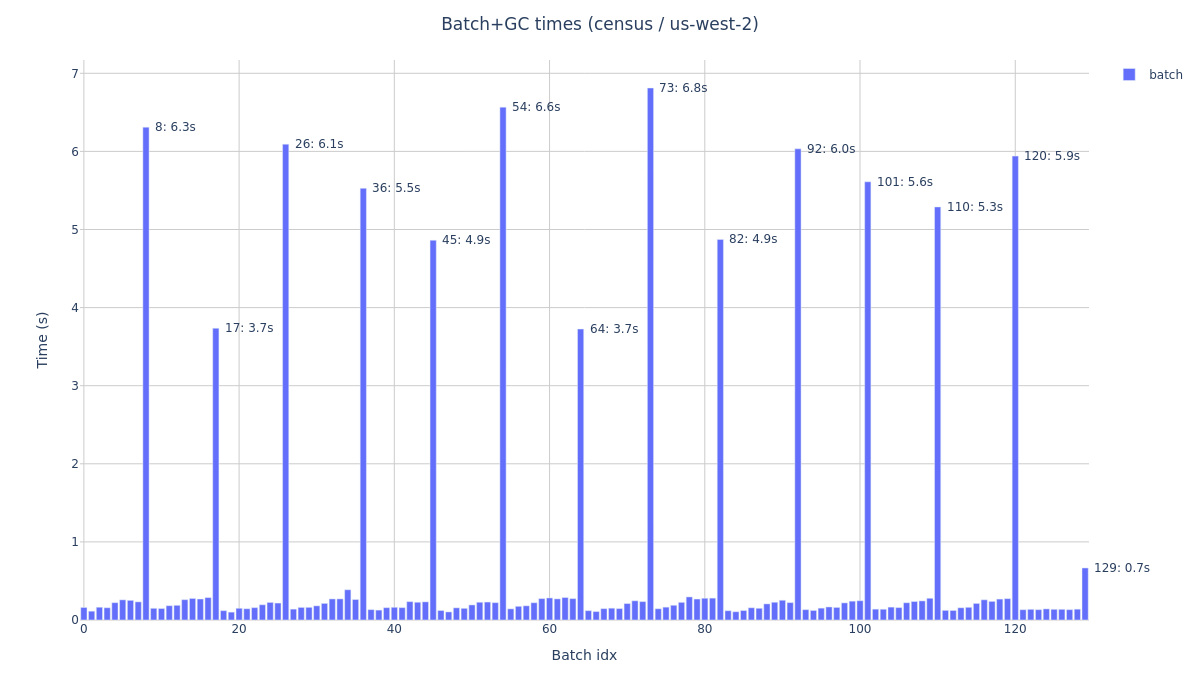

In [17]:
fig = px.bar(
    df.set_index('idx')[['batch', *(['gc'] if 'gc' in df else [])]],
    barmode='stack',
    labels={
        'idx': 'Batch idx',
        'variable': '',
        'value': 'Time (s)',
    },
    log_y=log_plot,
).update_layout(
    title=dict(text=f'Batch+GC times ({method} / {census_loc})'),
).update_xaxes(
    range=(-.5, len(df) - 1 + .5),
)

if not ann.empty:
    anns = ann.set_index('idx').batch.to_dict().items()
    for idx, batch in anns:
        fig.add_annotation(
            x=idx, y=log10(batch) if log_plot else batch,
            showarrow=False,
            text=f'{idx}: {batch:.1f}s',
            xshift=7,
            xanchor='left',
        )

plot(fig, f'census-{census_loc}', fmt='png', save=['png'], w=width, h=height, dir='img',)